In [32]:
import numpy as np
import pandas as pd
from stratmanager import StrategyManager
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt
from datetime import datetime

# Data extraction & Returns Overview

In [33]:
# Data Extraction
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
symbol = "BTC-USD"
strat_mgr = StrategyManager(symbol , start_date , end_date)
df = strat_mgr.df.copy()

df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2023-08-28,26089.615234,26198.578125,25880.599609,26106.150391,11002805166,0.000631,0.012286,2.966457
2023-08-29,26102.486328,28089.337891,25912.628906,27727.392578,29368391712,0.062102,0.084002,3.212583
2023-08-30,27726.083984,27760.160156,27069.207031,27297.265625,16343655235,-0.015513,0.025525,3.147943
2023-08-31,27301.929688,27456.078125,25752.929688,25931.472656,20181001451,-0.050034,0.066134,2.940792
2023-09-01,25934.021484,26125.869141,25362.609375,25800.724609,17202862221,-0.005042,0.030094,2.920950


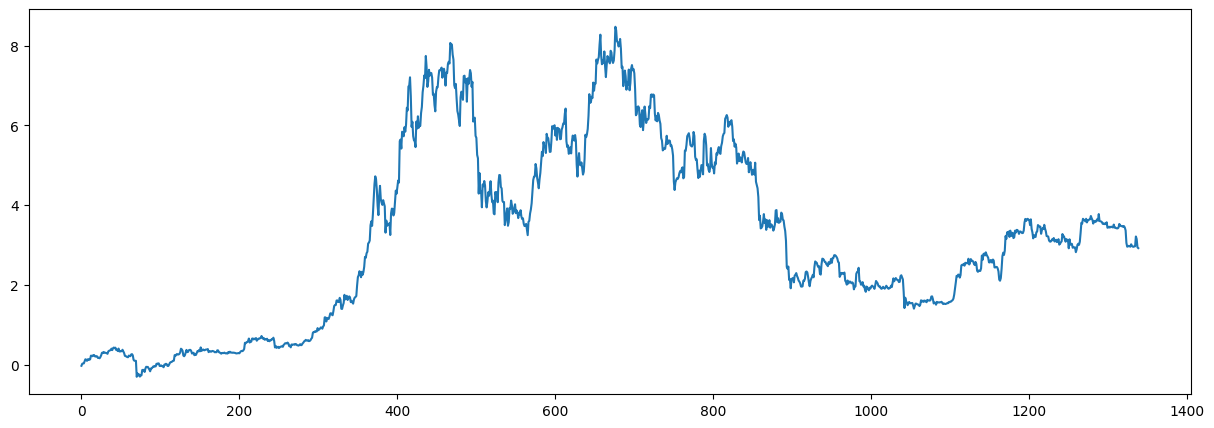

In [34]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15,5))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

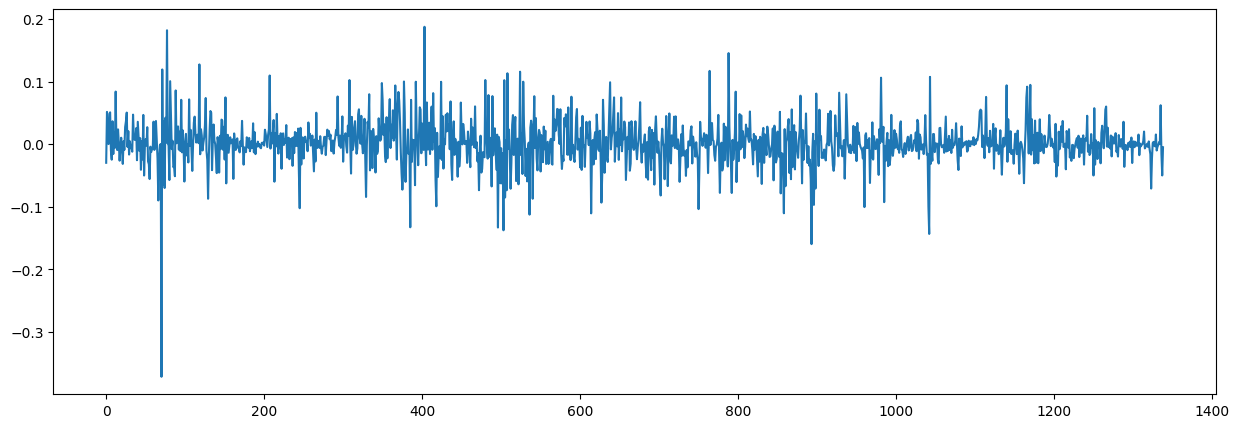

In [35]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15,5))
plt.plot(df["Returns"].values)
plt.show()

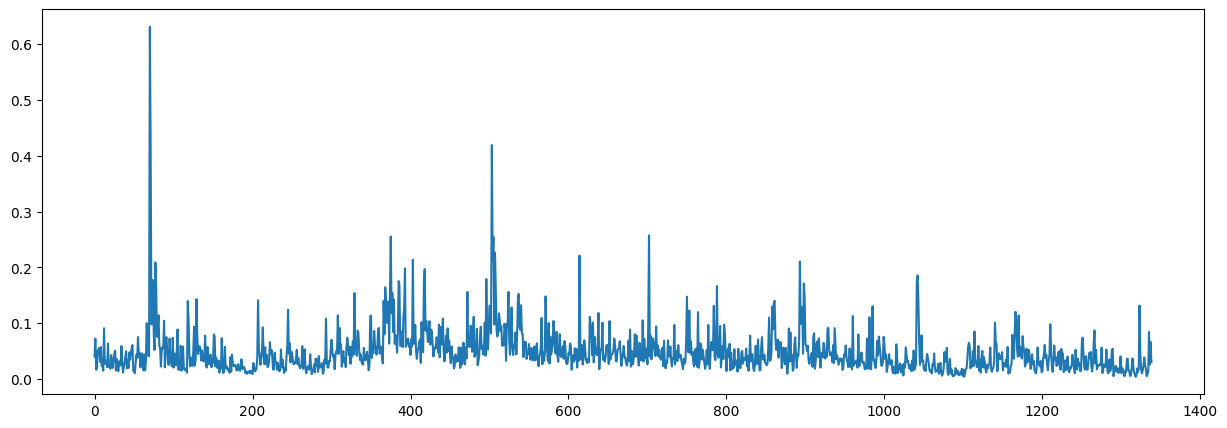

In [36]:
fig = plt.figure(figsize=(15,5))
plt.plot(df["Range"].values)
plt.show()

# Feature Engineering - Feature Expantion

In [37]:
df_fe = df.copy()

# Indicators

In [38]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi

df_fe["RSI_Return"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [39]:
# Add moving averages
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [40]:
# Day of the week
df_fe["DOW"] = df_fe.index.dayofweek

In [41]:
# Rolling Cumalitive returns
df_fe["Rolling_rets"] = df_fe["Returns"].rolling(window=30).sum()

In [42]:
# Rolling Cumalitive Range
df_fe["AVG_Range"] = df_fe["Range"].rolling(window=30).mean()

## Time Intervals

In [43]:
# Add Time Intervals
time_steps = [1,2]
time_features = ["Returns", "Range", "Rolling_rets"]
for ts in time_steps:
    for tf in time_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

### Feature Engineering

In [44]:
# Correct for stationarity
df_stationary = df_fe.copy()

df_stationary[["Open","High","Low","Volume"]] = df_stationary[["Open","High","Low","Volume"]].pct_change()

# ASSES DATA FOR ML READINESS

In [45]:
# Check for NaN
df_stationary = df_stationary.dropna()

In [46]:
# Check for inf values
dfobj = df_stationary.isin([np.inf,-np.inf])
count = np.isinf(dfobj).values.sum()

In [47]:
# Check for non numerical objects
df_stationary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1308 entries, 2020-02-02 to 2023-09-01
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1308 non-null   float64
 1   High             1308 non-null   float64
 2   Low              1308 non-null   float64
 3   Close            1308 non-null   float64
 4   Volume           1308 non-null   float64
 5   Returns          1308 non-null   float64
 6   Range            1308 non-null   float64
 7   Bench_C_Rets     1308 non-null   float64
 8   RSI              1308 non-null   float64
 9   RSI_Return       1308 non-null   float64
 10  MA_12            1308 non-null   float64
 11  MA_21            1308 non-null   float64
 12  DOW              1308 non-null   int64  
 13  Rolling_rets     1308 non-null   float64
 14  AVG_Range        1308 non-null   float64
 15  Returns_T1       1308 non-null   float64
 16  Range_T1         1308 non-null   float64
 

In [48]:
# describe dataframe
df_stationary.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Return,...,MA_21,DOW,Rolling_rets,AVG_Range,Returns_T1,Range_T1,Rolling_rets_T1,Returns_T2,Range_T2,Rolling_rets_T2
count,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,...,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000
mean,0.001443,0.001262,0.001476,28927.246487,0.040704,0.001435,0.047857,3.248027,52.187472,1.004770,...,28793.526398,2.998471,0.046943,0.047888,0.001442,0.047844,0.047267,0.001467,0.047818,0.047575
std,0.035998,0.031086,0.036995,15449.242011,0.327763,0.035939,0.040912,2.225419,13.912505,0.104860,...,15379.604996,2.000764,0.206989,0.020719,0.035939,0.040920,0.207067,0.035914,0.040919,0.207105
min,-0.365924,-0.263712,-0.364062,4970.788086,-0.869188,-0.371695,0.003596,-0.305805,14.037826,0.456113,...,5984.235073,0.000000,-0.613606,0.015756,-0.371695,0.003596,-0.613606,-0.371695,0.003596,-0.613606
25%,-0.013872,-0.011962,-0.011384,16879.269531,-0.144309,-0.013900,0.023721,1.557069,42.505209,0.952192,...,16924.064267,1.000000,-0.084806,0.033545,-0.013900,0.023710,-0.084639,-0.013900,0.023710,-0.084059
50%,0.000384,-0.000588,0.002457,27124.326172,-0.005708,0.000314,0.038399,3.116690,50.647480,1.000892,...,27080.636114,3.000000,0.024115,0.045243,0.000333,0.038399,0.024458,0.000333,0.038360,0.024830
75%,0.017106,0.013267,0.015368,40292.477539,0.169465,0.017010,0.058077,5.031120,61.123581,1.047693,...,40511.430478,5.000000,0.194982,0.055466,0.017010,0.058077,0.195097,0.017010,0.057992,0.195205
max,0.187677,0.187159,0.247892,67566.828125,5.439003,0.187465,0.631387,8.471219,90.719434,1.915829,...,63016.876488,6.000000,0.818827,0.118472,0.187465,0.631387,0.818827,0.187465,0.631387,0.818827


## SAVE DATAFRAME

In [49]:
# use or create folder to save data
import os

folder_name = 'data'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"'{folder_name}' has been created")
else:
    print(f"'{folder_name}' already exists")

'data' already exists


In [50]:
# save dataframe into csv
df_stationary.to_csv(f"{folder_name}/{symbol}.csv")